# Loan Management 
Building the loan management models: The first model is a clustering model that groops customer into different groups according to the amount of loan they can repay. The second is a classication model that classifies a customer as future defaulter or non defaulter. The third is a model that can determine the exact amount a customer can repay.

In [ ]:
# ! pip install xgboost
# ! pip install catboost
# ! pip install shap
# ! pip install lightgbm
# ! pip install optuna

In [75]:
# importing the needed library
import shap
import math
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, silhouette_score, calinski_harabasz_score, mean_squared_error, r2_score

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist

import optuna
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from joblib import dump
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [76]:
#loading the data
data = pd.read_csv("/content/drive/MyDrive/loan management/credit_train.csv")

In [78]:
#The shape is the number of rows available in the dataseta and also the number of columns
data.shape

(100514, 19)

In [79]:
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


In [80]:
#Names of all the columns available in the dataset
data.columns

Index(['Loan ID', 'Customer ID', 'Loan Status', 'Current Loan Amount', 'Term',
       'Credit Score', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Months since last delinquent', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

In [81]:
#Basic inforamation about the structure of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Term                          100000 non-null  object 
 5   Credit Score                  80846 non-null   float64
 6   Annual Income                 80846 non-null   float64
 7   Years in current job          95778 non-null   object 
 8   Home Ownership                100000 non-null  object 
 9   Purpose                       100000 non-null  object 
 10  Monthly Debt                  100000 non-null  float64
 11  Years of Credit History       100000 non-null  float64
 12  Months since last delinquent  46859 non-null

The dataset is made up of float and object dtypes. Most of the information are in the float format.

## EDA: To Extract and identify behavioural patterns to determine the eligibility of customers to loans 

In [82]:
#checking for missing values
data.isnull().sum()

Loan ID                           514
Customer ID                       514
Loan Status                       514
Current Loan Amount               514
Term                              514
Credit Score                    19668
Annual Income                   19668
Years in current job             4736
Home Ownership                    514
Purpose                           514
Monthly Debt                      514
Years of Credit History           514
Months since last delinquent    53655
Number of Open Accounts           514
Number of Credit Problems         514
Current Credit Balance            514
Maximum Open Credit               516
Bankruptcies                      718
Tax Liens                         524
dtype: int64

Due to the large number of missing values in the dataset,those missing values will be remove as filling them with a value can impact the acciracy of the data

In [83]:
data = data.dropna()
data.shape

(36423, 19)

Though the shape of the dataset reduced reasonably, the remainder is still significant enough to try the model efficiently.

In [84]:
#Checking the total number of customers 
(f"The total number of customers are {data['Customer ID'].nunique()}")

'The total number of customers are 29490'

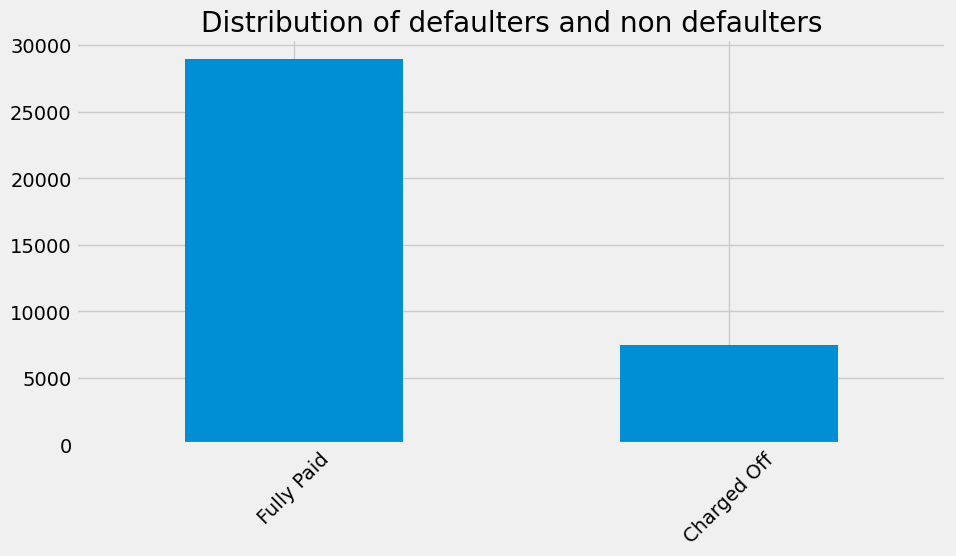

In [85]:
#Checking for the number of customer that repay and didn't repay their loan
plt.figure(figsize = (10, 5))
data['Loan Status'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=45) 
plt.title("Distribution of defaulters and non defaulters")
plt.show()

Most of the customers repaid their loans

In [87]:
#Select relevant column for further analysis
df = data[['Loan Status', 'Current Loan Amount', 'Term',
       'Credit Score', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens']]
df.head()

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Number of Credit Problems,Bankruptcies,Tax Liens
2,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,1.0,0.0,0.0
6,Fully Paid,217646.0,Short Term,730.0,1184194.0,< 1 year,Home Mortgage,Debt Consolidation,1.0,1.0,0.0
8,Fully Paid,548746.0,Short Term,678.0,2559110.0,2 years,Rent,Debt Consolidation,0.0,0.0,0.0
10,Fully Paid,99999999.0,Short Term,728.0,714628.0,3 years,Rent,Debt Consolidation,0.0,0.0,0.0
12,Fully Paid,99999999.0,Short Term,740.0,776188.0,< 1 year,Own Home,Debt Consolidation,0.0,0.0,0.0


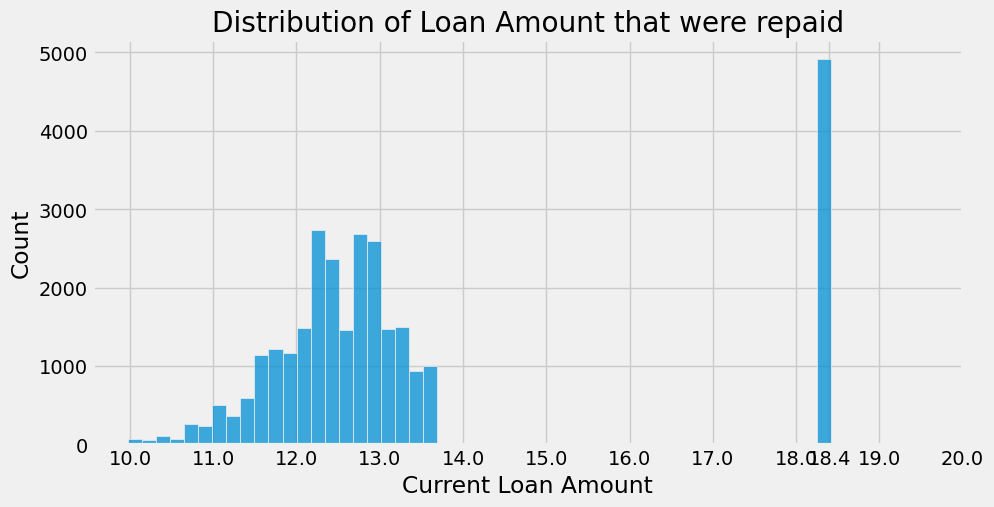

In [88]:
plt.figure(figsize = (10, 5))
a_df = df[df['Loan Status'] == 'Fully Paid'] #selecting only the instances in which the loans were repaid
sns.histplot(np.log(a_df['Current Loan Amount']), bins = 50)
plt.title("Distribution of Loan Amount that were repaid")
plt.xticks([10,11,12, 13, 14, 15, 16, 17, 18, 18.4,19, 20])
plt.show()

In [89]:
print(f"18 to the original number is: {np.exp(18)}\n19 to the original number is: {np.exp(19)}")
print(f"18.4 to the original number is: {np.exp(18.4)}")

18 to the original number is: 65659969.13733051
19 to the original number is: 178482300.96318725
18.4 to the original number is: 97953163.60543309


The data was tranformed to the logarithmic value for easy plotting of the graph, hence the number on the graph will be converted to get the original values using the inverse of np.log which is np.exp

* The most repaid loan fall between 65659969 and 178482300 approoximately which is 18 and 19 on the graph above. and specifically around 18.4 which is aproximately 97953167

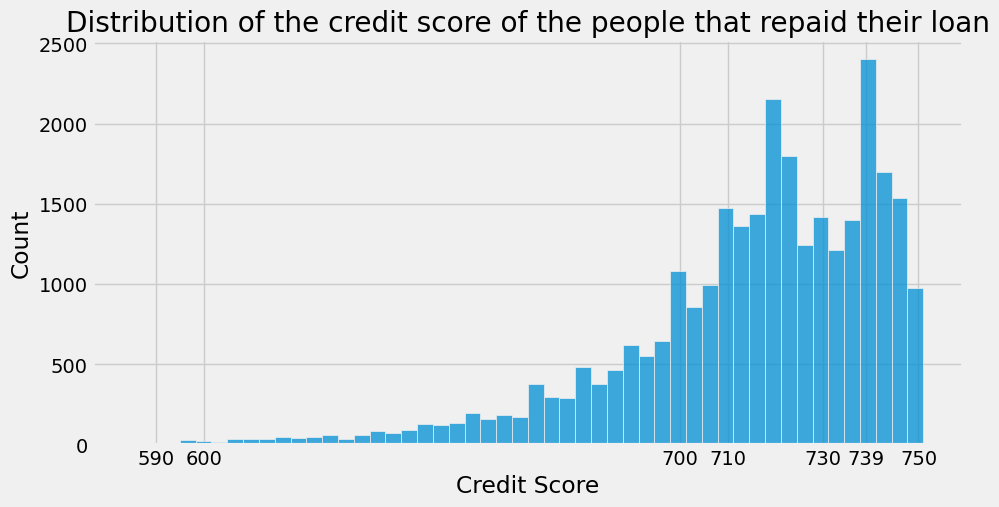

In [90]:
plt.figure(figsize = (10, 5))
a_df = df[df['Loan Status'] == 'Fully Paid'] #selecting only the instances in which the loans were repaid
sns.histplot(a_df['Credit Score'], bins = 50)
plt.title("Distribution of the credit score of the people that repaid their loan")
plt.xticks([590,600,700, 710, 730, 739,750])
plt.show()

* People with credit score of 739 and 740 repays their loan 

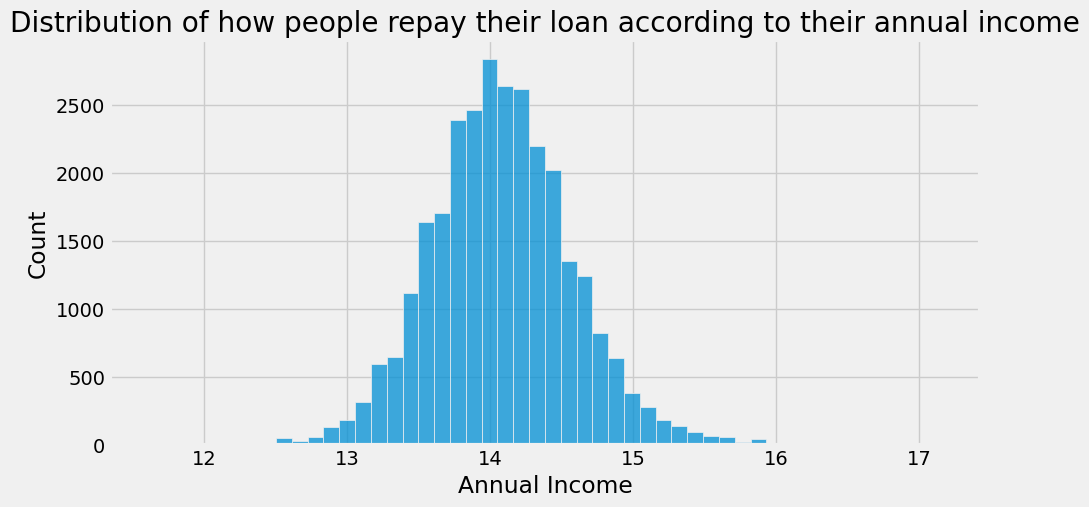

In [91]:
plt.figure(figsize = (10, 5))
a_df = df[df['Loan Status'] == 'Fully Paid'] #selecting only the instances in which the loans were repaid
sns.histplot(np.log(a_df['Annual Income']), bins = 50)
plt.title("Distribution of how people repay their loan according to their annual income")
plt.xticks([12,13,14, 15, 16, 17])
plt.show()

In [92]:
print(f"People with an annual income of approximately {round(np.exp(14), 0)} repays their loan")

People with an annual income of approximately 1202604.0 repays their loan


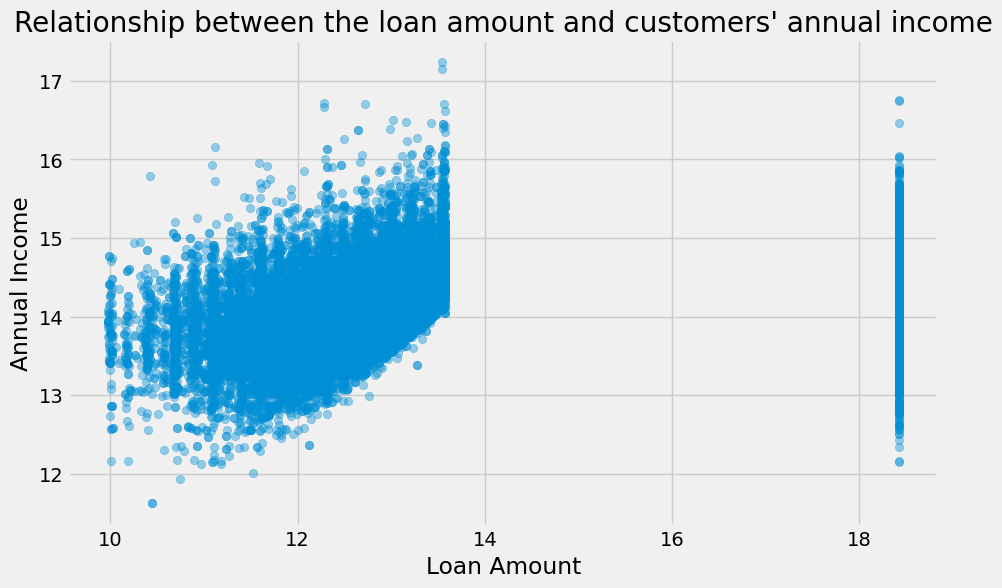

In [93]:
plt.figure(figsize = (10, 6))
plt.scatter(np.log(df['Current Loan Amount']), np.log(df['Annual Income']), alpha = 0.4)
plt.title("Relationship between the loan amount and customers' annual income")
plt.xlabel("Loan Amount")
plt.ylabel("Annual Income")
plt.show()

There is a positive correlation between the annual income and loan amount meaning that, as the Income increases the loan they tend to borrow also increases except in few instances.



In [94]:
df.columns

Index(['Loan Status', 'Current Loan Amount', 'Term', 'Credit Score',
       'Annual Income', 'Years in current job', 'Home Ownership', 'Purpose',
       'Number of Credit Problems', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

In [95]:
p_df = df.copy()
p_df['Current Loan Amount'] = np.log(df['Current Loan Amount'])
p_df['Annual Income'] = np.log(df['Annual Income'])
fig = px.scatter(
    data_frame=p_df,
    x = "Current Loan Amount",
    y= "Annual Income",
    title = "Relationship between Annual Income, Current Loan amount according to loan repayment",
    color = "Loan Status",
    width=1000,
    height=500
)
fig.show()

As the loan amount increases and the annual income increases, the person tend to default on their loan. Meaning people with high income should not be given large loans 

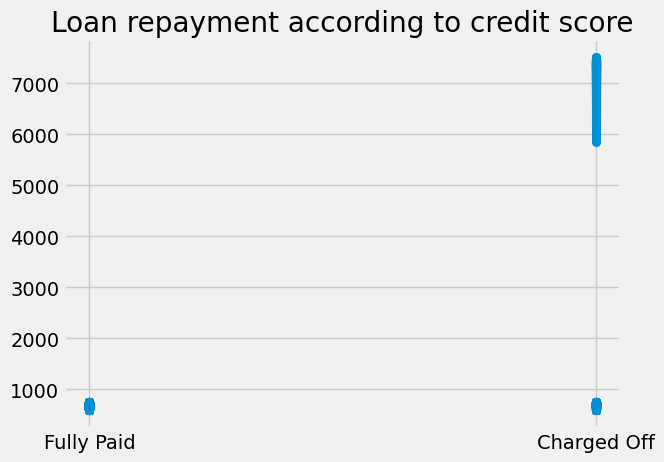

In [96]:
plt.scatter(df['Loan Status'], df['Credit Score'])
plt.title("Loan repayment according to credit score")
plt.show()

* Even with an high credit score, more people did not repay their loan

In [97]:
print(f"The highest amount of loan is {df['Current Loan Amount'].max()}\n")
print(f"The lowest amount of loan is {df['Current Loan Amount'].min()}")

The highest amount of loan is 99999999.0

The lowest amount of loan is 21450.0


In [98]:
# distribution of loan repaymemt according to loan amount
data[(data['Current Loan Amount'] == 99999999.0)]['Loan Status'].value_counts()

Fully Paid    4918
Name: Loan Status, dtype: int64

In [99]:
# distribution of loan repaymemt according to loan amount
data[(data['Current Loan Amount'] == 21450.0)]['Loan Status'].value_counts()

Charged Off    1
Name: Loan Status, dtype: int64

* All the people that obtained the latgest amount of loans where all able to repay
* Only a single person was obatained the lowest amount of loans and wasn't able to repay

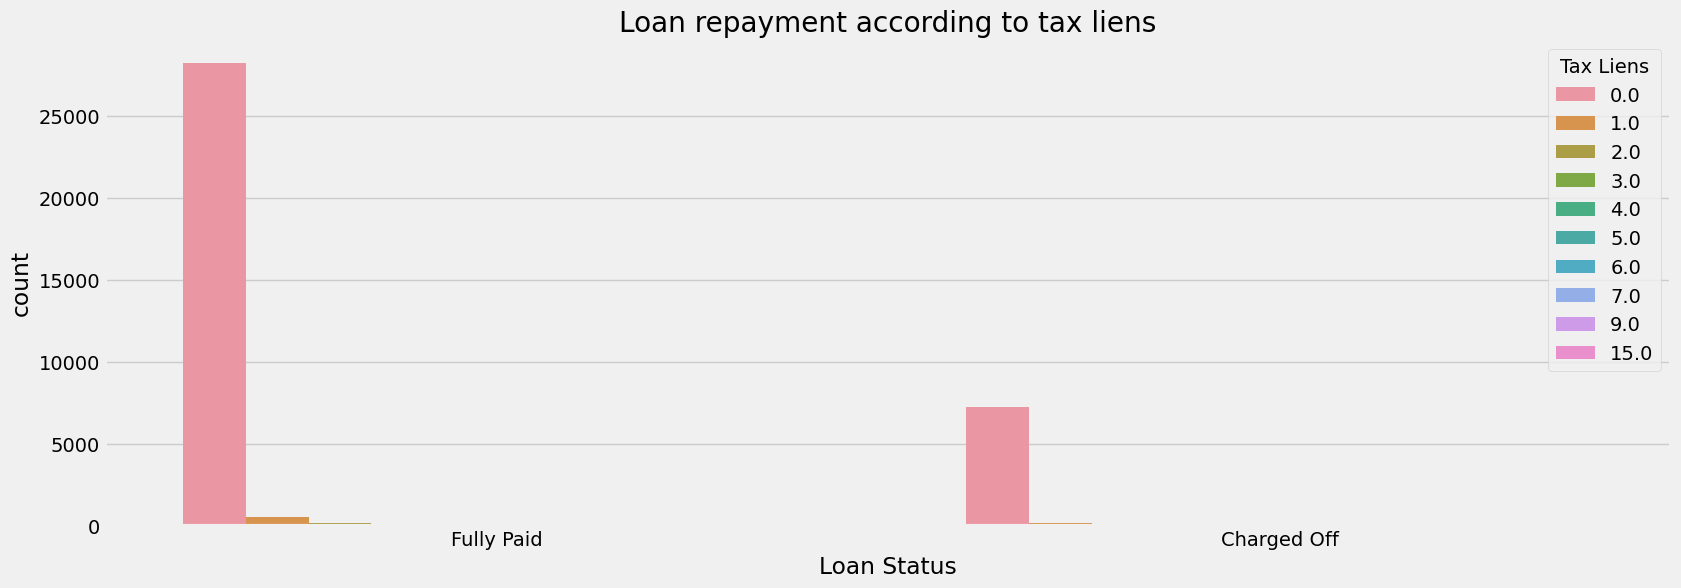

In [100]:
plt.figure(figsize=(18, 6))
sns.countplot(x = df['Loan Status'], hue = df['Tax Liens']).set_title('Loan repayment according to tax liens')
plt.show()

* Customers with fewer Tax lien often repays their loan

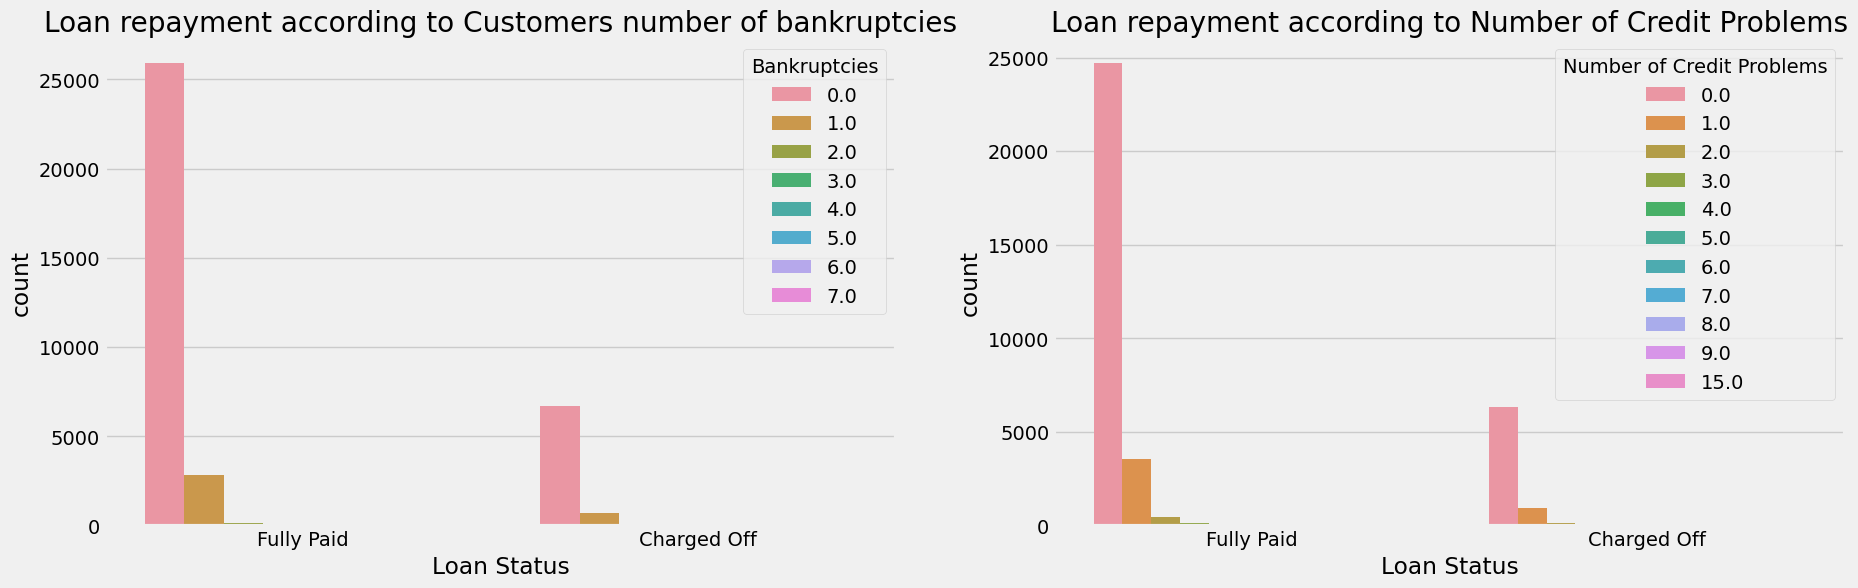

In [101]:
fig, ax = plt.subplots(1, 2, figsize = [20, 6])
sns.countplot(x = df['Loan Status'], hue = df['Bankruptcies'], ax = ax[0]).set_title('Loan repayment according to Customers number of bankruptcies')
sns.countplot(x = df['Loan Status'], hue = df['Number of Credit Problems'], ax = ax[1]).set_title('Loan repayment according to Number of Credit Problems')
plt.show()

* Customers with fewer bankruptcies often repays their loan
* Customers with fewer credit problems also repay their loan often
  
  Little bit of correlation can be observed from the two columns 

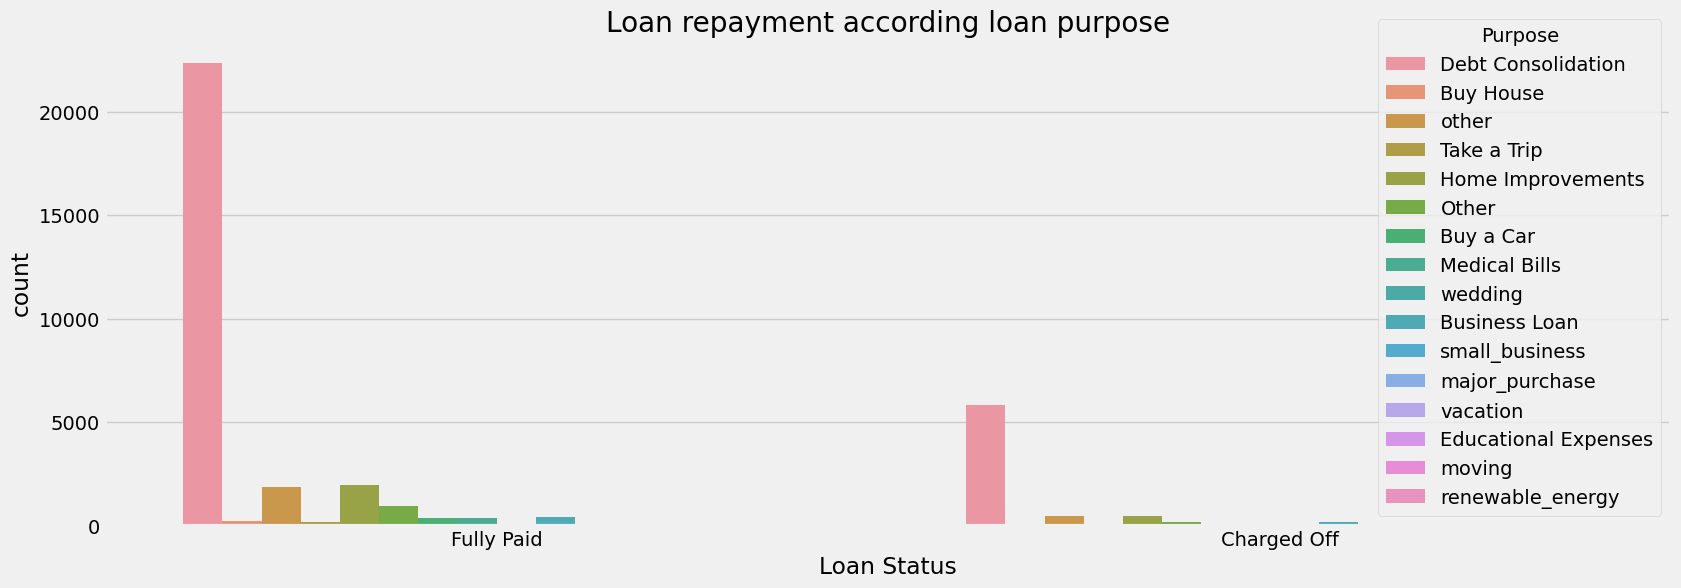

In [102]:
plt.figure(figsize=(18, 6))
sns.countplot(x = df['Loan Status'], hue = df['Purpose']).set_title('Loan repayment according loan purpose')
plt.show()

* Loans used for debt consolidation received high repay

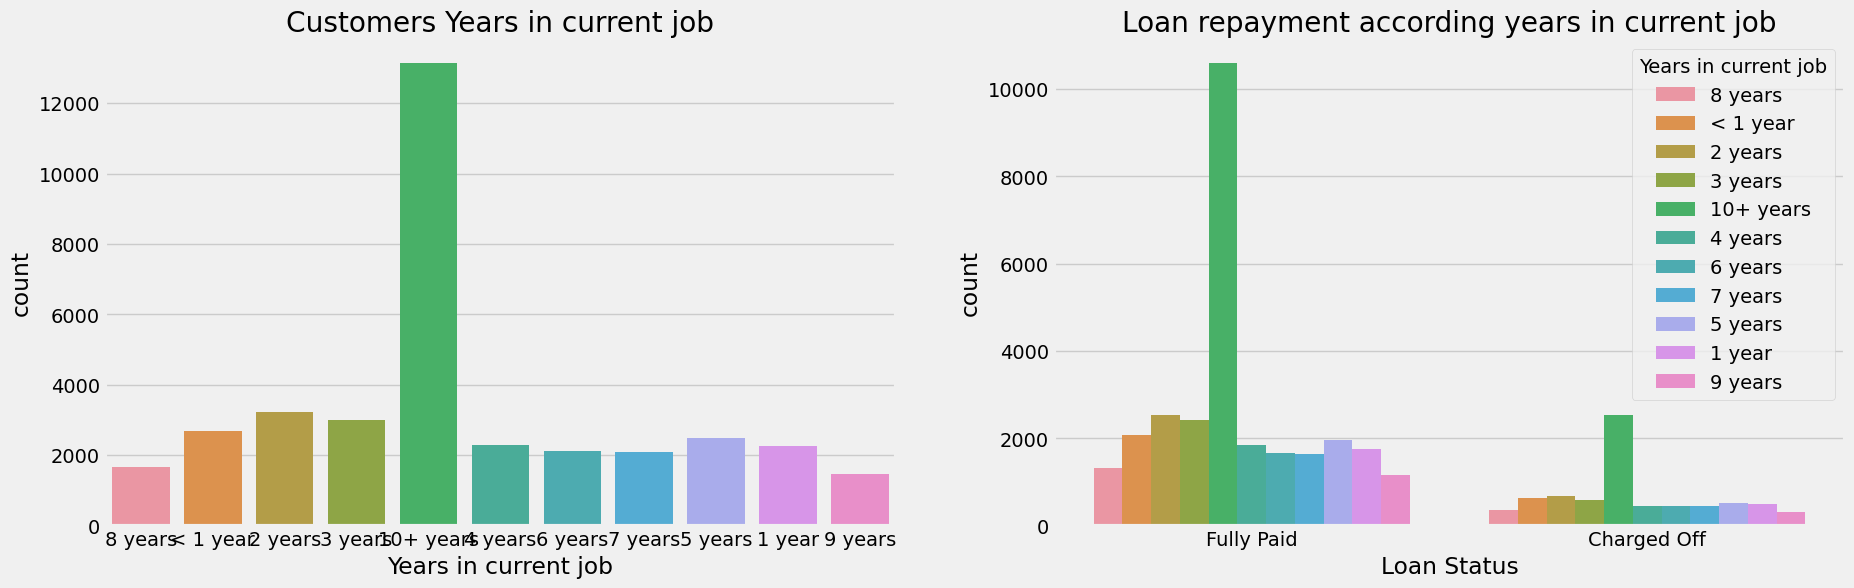

In [103]:
fig, ax = plt.subplots(1, 2, figsize = [20, 6])
sns.countplot(x = df['Years in current job'], ax = ax[0]).set_title('Customers Years in current job')
sns.countplot(x = df['Loan Status'], hue = df['Years in current job'], ax = ax[1]).set_title('Loan repayment according years in current job')
plt.show()

* Most of the customers has spent up to 10 years on their current job 
* Most of these custoners that has spent up to 10 years on their currect job repaid their loan

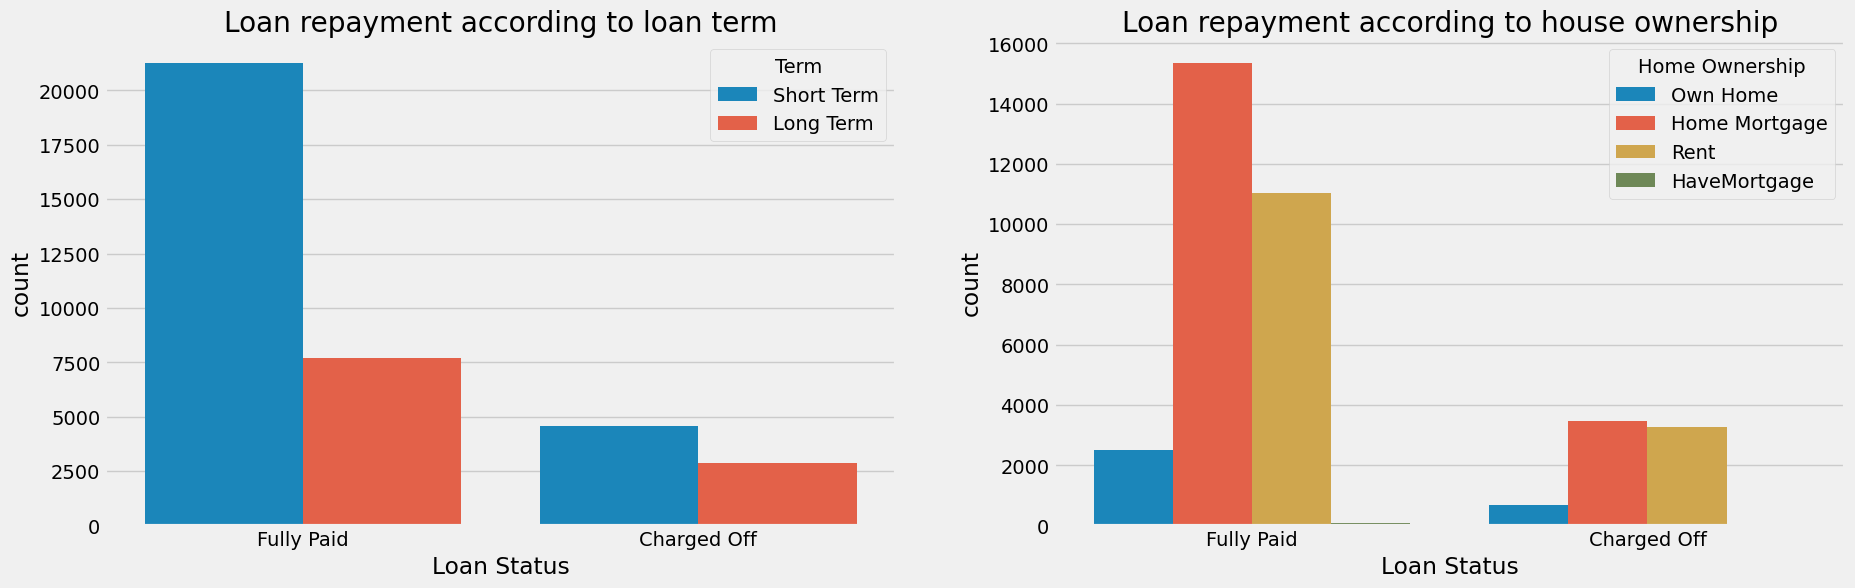

In [104]:
fig, ax = plt.subplots(1, 2, figsize = [20, 6])
sns.countplot(x = df['Loan Status'], hue = df['Term'], ax = ax[0]).set_title('Loan repayment according to loan term')
sns.countplot(x = df['Loan Status'], hue = df['Home Ownership'], ax = ax[1]).set_title('Loan repayment according to house ownership')
plt.show()

* Most of the loan that were repaid are short term loans
* Most of the loan that were repaid were borrowed by customers who acquire their house by home mortgage

In [105]:
print(f"The highest amount of loan is {df['Current Loan Amount'].max()}\n")
print(f"The lowest amount of loan is {df['Current Loan Amount'].min()}")

The highest amount of loan is 99999999.0

The lowest amount of loan is 21450.0


From the analysis above, It is obvious that the criterias that affect customer eligiblity are:


*   Credit Score: People with high credit score generally repay their loan especiall people with credit score of around 739 and 740 

*   Annual Income: Poeople with high income can be considered for loan especially people with annual income of 1202604


*   Current loan amount: loan of around 97953167 should be given out more as people tend to repay such loan 

*   Loan type: short term loans should be givven out more than the long term loan


*   Number of Credit Problems, Bankruptcies, Tax Liens: customers with lesser number in these three factors performs better in loan repayment

*   Years in current job: people with high number of years in current job often repay

* Poeple with both high income and high loan were found to default. hence, poeple with high income shouldn't be given large loans






## Data Preprocessing

In [106]:
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
6,273581de-85d8-4332-81a5-19b04ce68666,90a75dde-34d5-419c-90dc-1e58b04b3e35,Fully Paid,217646.0,Short Term,730.0,1184194.0,< 1 year,Home Mortgage,Debt Consolidation,10855.08,19.6,10.0,13.0,1.0,122170.0,272052.0,1.0,0.0
8,8af915d9-9e91-44a0-b5a2-564a45c12089,af534dea-d27e-4fd6-9de8-efaa52a78ec0,Fully Paid,548746.0,Short Term,678.0,2559110.0,2 years,Rent,Debt Consolidation,18660.28,22.6,33.0,4.0,0.0,437171.0,555038.0,0.0,0.0
10,32c2e48f-1ba8-45e0-a530-9a6622c18d9c,0de7bcdb-ebf4-4608-ba39-05f083f855b6,Fully Paid,99999999.0,Short Term,728.0,714628.0,3 years,Rent,Debt Consolidation,11851.06,16.0,76.0,16.0,0.0,203965.0,289784.0,0.0,0.0
12,403d7235-0284-4bb6-919a-09402fecbf7b,11581f68-de3c-49d8-80d9-22268ebb323b,Fully Paid,99999999.0,Short Term,740.0,776188.0,< 1 year,Own Home,Debt Consolidation,11578.22,8.5,25.0,6.0,0.0,134083.0,220220.0,0.0,0.0


In [107]:
#Encoding categorical vaiables
obj_col = ['Term', 'Years in current job', 'Home Ownership', 'Purpose']

encoder = OrdinalEncoder()
for i in obj_col:
  data[[i]] = encoder.fit_transform(data[[i]])

In [108]:
ls = {'Fully Paid': 1, 'Charged Off': 0} # 0 will represent charged off(non repaid) while 1 will represent fully paid
data['Loan Status'] = data['Loan Status'].map(ls)

In [109]:
data = data.drop(['Loan ID',	'Customer ID'], axis = 1)
data.head()

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
2,1,99999999.0,1.0,741.0,2231892.0,8.0,2.0,3.0,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
6,1,217646.0,1.0,730.0,1184194.0,10.0,1.0,3.0,10855.08,19.6,10.0,13.0,1.0,122170.0,272052.0,1.0,0.0
8,1,548746.0,1.0,678.0,2559110.0,2.0,3.0,3.0,18660.28,22.6,33.0,4.0,0.0,437171.0,555038.0,0.0,0.0
10,1,99999999.0,1.0,728.0,714628.0,3.0,3.0,3.0,11851.06,16.0,76.0,16.0,0.0,203965.0,289784.0,0.0,0.0
12,1,99999999.0,1.0,740.0,776188.0,10.0,2.0,3.0,11578.22,8.5,25.0,6.0,0.0,134083.0,220220.0,0.0,0.0


## Model Training 
### Clustering customers into different groups according to loan amount and credit score(Important factor )

#### Kmeans 

In [110]:
cluster_df = df[['Annual Income', 'Current Loan Amount']] #Selecting only the loan amount and credit score columns

In [111]:
norm = Normalizer()

cluster_df[['Annual Income', 'Current Loan Amount']] = norm.fit_transform(cluster_df[['Annual Income', 'Current Loan Amount']])

In [112]:
cluster_df = cluster_df.values #Retrieving only the values in the dataset
cluster_df

array([[0.02231336, 0.99975103],
       [0.98352636, 0.18076479],
       [0.97777381, 0.20966253],
       ...,
       [0.96571732, 0.25959596],
       [0.01289309, 0.99991688],
       [0.9960063 , 0.089283  ]])

In [113]:
# finding wcss(within-cluster sum of squares) value for different number of clusters

wcss = []

for i in range(1, 15):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
  kmeans.fit(cluster_df)

  wcss.append(kmeans.inertia_)

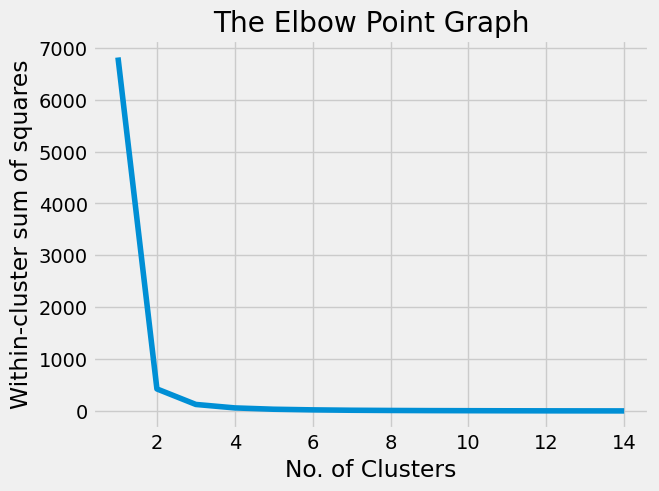

In [114]:
# plot an elbow graph to determine best no of clusters
plt.plot(range(1,15), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('No. of Clusters')
plt.ylabel('Within-cluster sum of squares')
plt.show()

Best cluster number is 4
The model will then be retrained setting number of clusters to 2

In [115]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=44)

# return a label for each data point based on their cluster
y = kmeans.fit_predict(cluster_df)

print(y)

[1 0 0 ... 0 1 2]


In [116]:
print(f"Calinski Harabasz Score for kmeans: {calinski_harabasz_score(cluster_df, y)}")
print(f"Inertia for kmeans: {kmeans.inertia_}")
print(f"silhouette coefficient for kmeans: {silhouette_score(cluster_df, kmeans.labels_)}")

Calinski Harabasz Score for kmeans: 1316731.940390438
Inertia for kmeans: 62.24897257300543
silhouette coefficient for kmeans: 0.616731975755238


#### Hierarchical Clustering: 
##### Agglomerative Hierarchical clustering

In [117]:
hie_agg_clus = AgglomerativeClustering(n_clusters = 3, linkage='ward')
hie_agg_clus = hie_agg_clus.fit_predict(cluster_df)
ch_score = calinski_harabasz_score(cluster_df, hie_agg_clus)

print(f"Calinski Harabasz Score for Agglomerative Clustering: {calinski_harabasz_score(cluster_df, hie_agg_clus)}")
print(f"silhouette coefficient for Agglomerative Clustering: {silhouette_score(cluster_df, hie_agg_clus)}")

Calinski Harabasz Score for Agglomerative Clustering: 943689.6623199104
silhouette coefficient for Agglomerative Clustering: 0.6498894818722483


##### Divisive Hierarchical Clustering

In [118]:
hie_dis_clus = AgglomerativeClustering(n_clusters=None, distance_threshold=10, linkage='ward')
hie_dis_clus = hie_dis_clus.fit_predict(cluster_df)

print(f"Calinski Harabasz Score for Divisive Clustering: {calinski_harabasz_score(cluster_df, hie_dis_clus)}")
print(f"silhouette coefficient for Divisive Clustering: {silhouette_score(cluster_df, hie_dis_clus)}")

Calinski Harabasz Score for Divisive Clustering: 943689.6623199104
silhouette coefficient for Divisive Clustering: 0.6498894818722483


In [119]:
set(hie_dis_clus)

{0, 1, 2}

Of the three clustering models, hierarchical clustering models performed better with 3 clusters

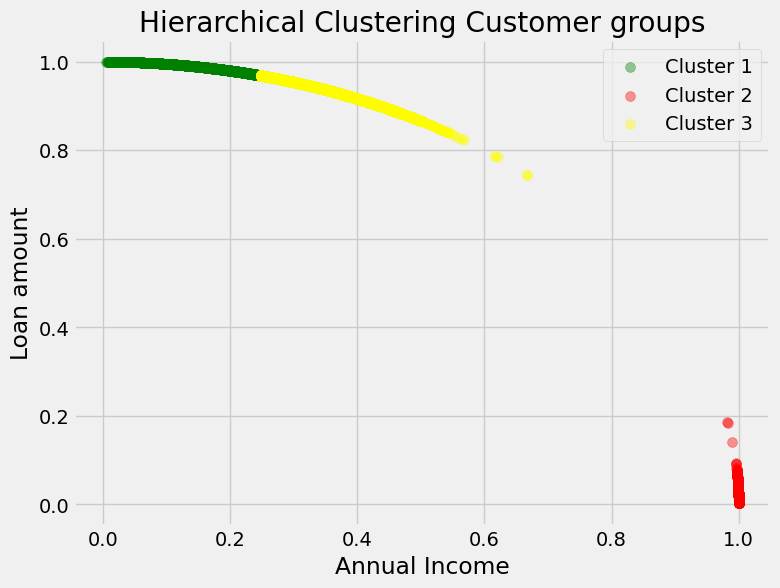

In [120]:
# plotting all the clusters

plt.figure(figsize=(8,6))
plt.scatter(cluster_df[hie_dis_clus==0,1], cluster_df[hie_dis_clus==0,0], s=50, c='green', label='Cluster 1', alpha = 0.4)
plt.scatter(cluster_df[hie_dis_clus==1,1], cluster_df[hie_dis_clus==1,0], s=50, c='red', label='Cluster 2', alpha=0.4)
plt.scatter(cluster_df[hie_dis_clus==2,1], cluster_df[hie_dis_clus==2,0], s=50, c='yellow', label='Cluster 3', alpha=0.4)

plt.title('Hierarchical Clustering Customer groups')
plt.xlabel('Annual Income')
plt.ylabel('Loan amount')
plt.legend()
plt.show()

From the cluster graph 


* Cluster 1 represent customers with High loan amount and low income 

* Cluster 2 represent customers with high loan amount and moderately high annual income

* Cluster 3 represent customers with low loan amount but high income



<!-- After the segmentation, Kmeans grouped the dataset into 4 groups
* Cluster 1 represent the customers with moderately high loan amount and moderately high income - Not eligible
* Cluster 2 represent the customers with varying loan amount and very high income - highly eligible
* Cluster 3 represent the customers with ranging from low to moderately high loan amount and low income - Eligible
* Cluster 4 represent customers with high loan amount and high annual income - highly not eligible -->


### Classification :To classify a customer as future defaulter or non defaulter

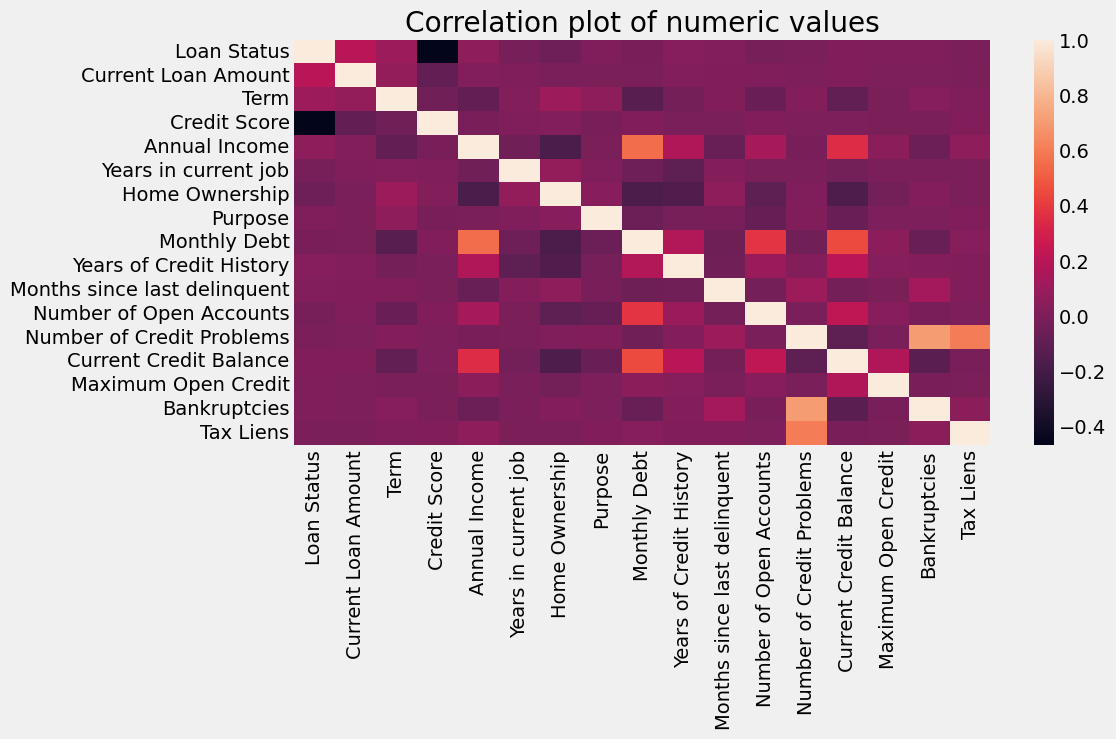

In [121]:
# Checking the correlation between the columns
class_df = data.copy()
plt.figure(figsize = (10, 5))
sns.heatmap(class_df.corr()).set_title("Correlation plot of numeric values")
plt.show()

Bankruptcies,monthly debt and tax liens will be dropped as a result of correlation with other column

In [122]:
x = class_df.drop(['Loan Status', 'Bankruptcies', 'Monthly Debt', 'Tax Liens'], axis = 1) # independent features
y = class_df['Loan Status'] # dependent features

In [123]:
# Splitting the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42) 

###### Model Training

In [124]:
cat_clf = CatBoostClassifier()
cat_clf.fit(x_train, y_train)

Learning rate set to 0.041067
0:	learn: 0.6587854	total: 61.3ms	remaining: 1m 1s
1:	learn: 0.6315277	total: 69.5ms	remaining: 34.7s
2:	learn: 0.6035662	total: 77.6ms	remaining: 25.8s
3:	learn: 0.5838189	total: 86ms	remaining: 21.4s
4:	learn: 0.5659784	total: 94.2ms	remaining: 18.7s
5:	learn: 0.5502671	total: 103ms	remaining: 17.1s
6:	learn: 0.5340244	total: 111ms	remaining: 15.8s
7:	learn: 0.5212137	total: 120ms	remaining: 14.9s
8:	learn: 0.5099325	total: 128ms	remaining: 14.1s
9:	learn: 0.4993936	total: 137ms	remaining: 13.5s
10:	learn: 0.4905155	total: 145ms	remaining: 13s
11:	learn: 0.4761943	total: 153ms	remaining: 12.6s
12:	learn: 0.4691178	total: 162ms	remaining: 12.3s
13:	learn: 0.4627855	total: 169ms	remaining: 11.9s
14:	learn: 0.4568913	total: 177ms	remaining: 11.6s
15:	learn: 0.4515524	total: 189ms	remaining: 11.6s
16:	learn: 0.4465875	total: 198ms	remaining: 11.5s
17:	learn: 0.4424140	total: 211ms	remaining: 11.5s
18:	learn: 0.4382144	total: 220ms	remaining: 11.4s
19:	learn:

In [125]:
xg_class = XGBClassifier()
xg_class.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [135]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

LogisticRegression()

In [127]:
lt_class = LGBMClassifier()
lt_class.fit(x_train, y_train)

LGBMClassifier()

In [134]:
#Writing a function to evaluate the performance of the models
def evaluate(model):
  y_pred = model.predict(x_test)
  print(f"The accuracy score of the {type(model).__name__} is {round(accuracy_score(y_test, y_pred) * 100)}%\n")
  print(f"The precision score of the {type(model).__name__} is {round(precision_score(y_test, y_pred) * 100)}%\n")
  print(f"The recall score of the {type(model).__name__} is {round(recall_score(y_test, y_pred) * 100)}%\n")

In [129]:
evaluate(lt_class)

The accuracy score of the LGBMClassifier is 85%

The precision score of the LGBMClassifier is 84%

The recall score of the LGBMClassifier is 99%



In [136]:
evaluate(log_reg)

The accuracy score of the LogisticRegression is 84%

The precision score of the LogisticRegression is 84%

The recall score of the LogisticRegression is 100%



In [137]:
evaluate(xg_class)

The accuracy score of the XGBClassifier is 84%

The precision score of the XGBClassifier is 84%

The recall score of the XGBClassifier is 98%



In [138]:
evaluate(cat_clf)

The accuracy score of the CatBoostClassifier is 85%

The precision score of the CatBoostClassifier is 84%

The recall score of the CatBoostClassifier is 99%



Perform cross validation on cat boost to ensure it's not overfitted

In [139]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(LogisticRegression(), x, y, cv=5, scoring='accuracy')
cv_scores.mean()

0.8457843725889935

In [140]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(CatBoostClassifier(), x, y, cv=5, scoring='accuracy')
cv_scores.mean()

Streaming output truncated to the last 5000 lines.
4:	learn: 0.5599065	total: 112ms	remaining: 22.3s
5:	learn: 0.5444139	total: 142ms	remaining: 23.6s
6:	learn: 0.5304466	total: 167ms	remaining: 23.6s
7:	learn: 0.5178568	total: 178ms	remaining: 22.1s
8:	learn: 0.4992369	total: 190ms	remaining: 20.9s
9:	learn: 0.4890371	total: 213ms	remaining: 21s
10:	learn: 0.4806149	total: 226ms	remaining: 20.3s
11:	learn: 0.4728186	total: 239ms	remaining: 19.6s
12:	learn: 0.4606618	total: 250ms	remaining: 19s
13:	learn: 0.4546263	total: 260ms	remaining: 18.3s
14:	learn: 0.4491125	total: 272ms	remaining: 17.9s
15:	learn: 0.4441610	total: 283ms	remaining: 17.4s
16:	learn: 0.4396451	total: 296ms	remaining: 17.1s
17:	learn: 0.4357858	total: 308ms	remaining: 16.8s
18:	learn: 0.4319314	total: 320ms	remaining: 16.5s
19:	learn: 0.4285144	total: 332ms	remaining: 16.2s
20:	learn: 0.4252840	total: 343ms	remaining: 16s
21:	learn: 0.4226975	total: 358ms	remaining: 15.9s
22:	learn: 0.4184496	total: 381ms	remaining

0.8497928386018829

According to the result of the cross validation the model was not overfitted nor underfitted

##### Hyperparameter tuning 

In [141]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'thread_count': 4,
        'loss_function': 'MultiClass',
        'eval_metric': 'Accuracy',
        'verbose': False,
        'random_seed': 42
    }
    
    # Train the CatBoost model with the current set of hyperparameters
    model = CatBoostClassifier(**params)
    model.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=20, verbose=False)
    
    # Evaluate the model on the validation set and return the accuracy
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best set of hyperparameters and the corresponding score
print('Best score:', study.best_value)
print('Best params:', study.best_params)

[I 2023-04-06 08:41:52,439] A new study created in memory with name: no-name-cdf6c475-0ee9-4854-a510-3337c23c9459
[I 2023-04-06 08:41:53,160] Trial 0 finished with value: 0.8457948201702206 and parameters: {'iterations': 263, 'learning_rate': 0.05673589742140842, 'depth': 9, 'l2_leaf_reg': 1.6982911462630859, 'border_count': 95}. Best is trial 0 with value: 0.8457948201702206.
[I 2023-04-06 08:41:53,429] Trial 1 finished with value: 0.8458863365974192 and parameters: {'iterations': 235, 'learning_rate': 0.010601505106711874, 'depth': 4, 'l2_leaf_reg': 0.04820317309095109, 'border_count': 128}. Best is trial 1 with value: 0.8458863365974192.
[I 2023-04-06 08:41:53,990] Trial 2 finished with value: 0.8440560080534456 and parameters: {'iterations': 228, 'learning_rate': 0.012751411197088414, 'depth': 9, 'l2_leaf_reg': 0.013041212239251629, 'border_count': 37}. Best is trial 1 with value: 0.8458863365974192.
[I 2023-04-06 08:41:54,332] Trial 3 finished with value: 0.8458863365974192 and pa

Best score: 0.8458863365974192
Best params: {'iterations': 235, 'learning_rate': 0.010601505106711874, 'depth': 4, 'l2_leaf_reg': 0.04820317309095109, 'border_count': 128}


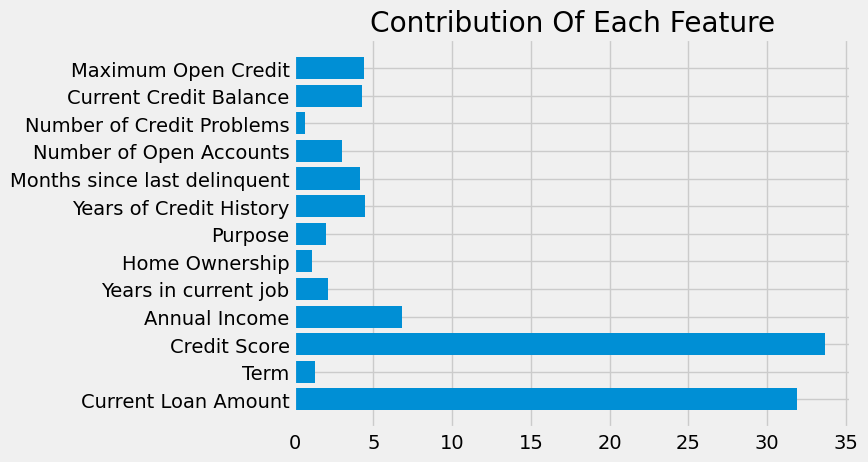

In [142]:
plt.barh(x.columns, cat_clf.feature_importances_)
plt.title("Contribution Of Each Feature")
plt.show()

The highest contribution came from the credit score and loan amount. these are important factors that determine if a person will repay their loan or not.

In [143]:
import pandas as pd

accuracy = {
    'model_name': ['XGBClassifier', 'CatBoost', 'LogisticRegression', 'LightGBM'],
    'accuracy_score': [84, 85, 84, 85]}

recall = {
    'model_name': ['XGBClassifier', 'CatBoost', 'LogisticRegression', 'LightGBM'],
    'recall_score': [98, 99, 100, 99]}

accuracy = pd.DataFrame(accuracy)

recall = pd.DataFrame(recall)

In [144]:
accuracy

,model_name,accuracy_score
0,XGBClassifier,84
1,CatBoost,85
2,LogisticRegression,84
3,LightGBM,85


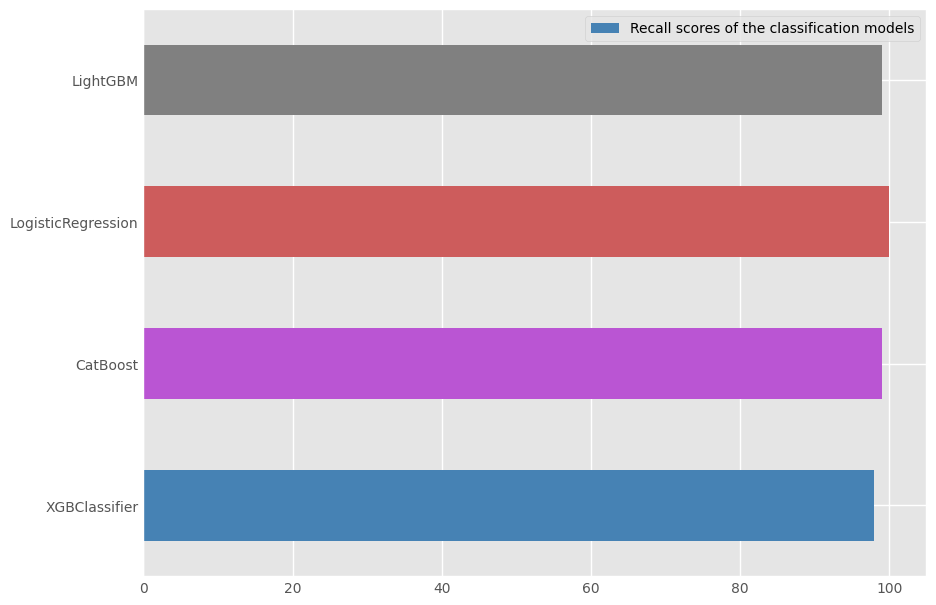

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
recall.plot(x = 'model_name', y = 'recall_score', kind = 'barh', figsize = (9, 7), label = 'Recall scores of the classification models', color = ['steelblue', 'mediumorchid', 'indianred', 'grey'])
plt.ylabel(None)
plt.show()

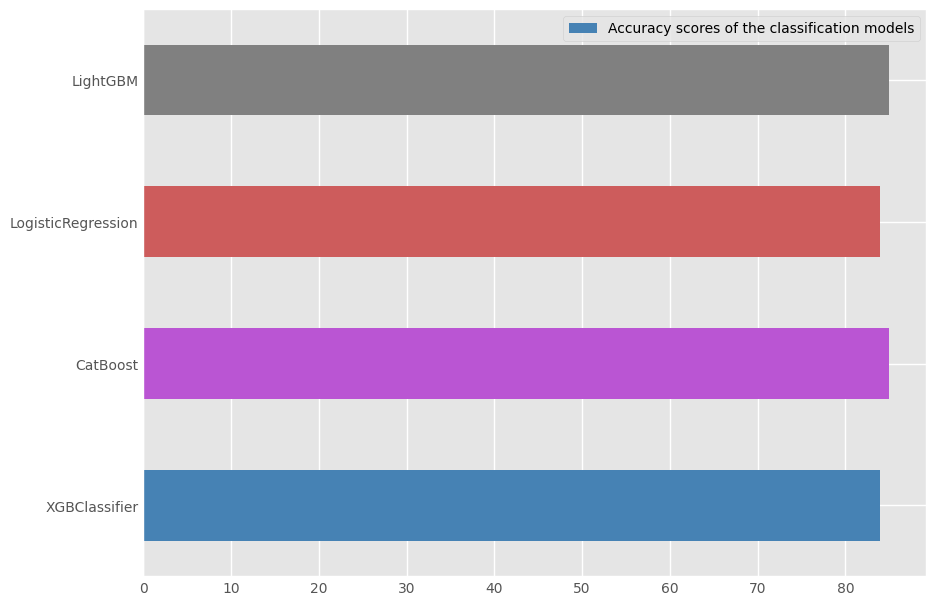

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
accuracy.plot(x = 'model_name', y = 'accuracy_score', kind = 'barh', figsize = (9, 7), label = 'Accuracy scores of the classification models', color = ['steelblue', 'mediumorchid', 'indianred', 'grey'])
plt.ylabel(None)
plt.show()

In [147]:
import pandas as pd

sc = {
    'model_name': ['KMeans', 'Hierarchical Clustering'],
    'sc_score': [0.616732, 0.649889]}

chs = {
    'model_name': ['KMeans', 'Hierarchical Clustering'],
    'chs_score': [1316731.94, 943689.66]}

sc = pd.DataFrame(sc)

chs = pd.DataFrame(chs)

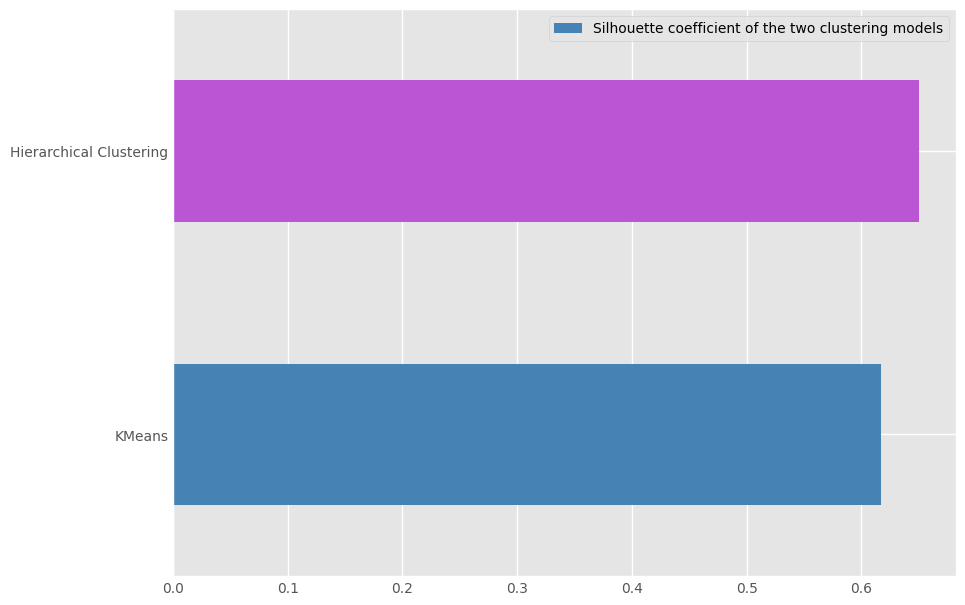

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sc.plot(x = 'model_name', y = 'sc_score', kind = 'barh', figsize = (9, 7), label = 'Silhouette coefficient of the two clustering models', color = ['steelblue', 'mediumorchid'])
plt.ylabel(None)
plt.show()

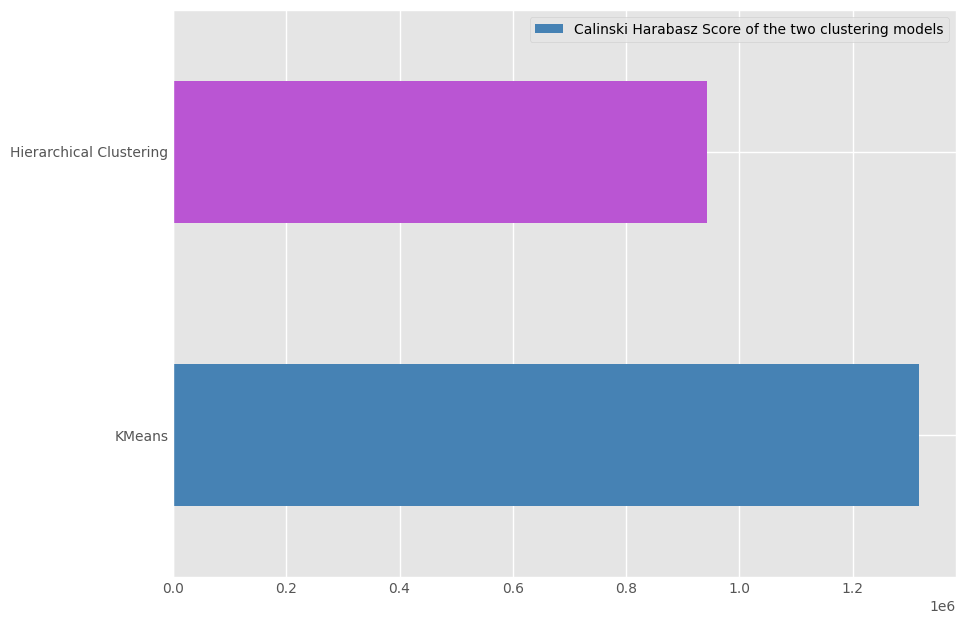

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
chs.plot(x = 'model_name', y = 'chs_score', kind = 'barh', figsize = (9, 7), label = 'Calinski Harabasz Score of the two clustering models', color = ['steelblue', 'mediumorchid'])
plt.ylabel(None)
plt.show()